## Exemples - méthodes de classification supervisée

### Termes quadratiques - Frontières quadratiques
---

In [1]:
rm(list = ls())
library(MASS)
library(RColorBrewer)
library(class)

mycols <- brewer.pal(8, "Dark2")[c(3,2)]

In [2]:
#sink("classification-out.txt")

#########
# Plots showing decision boundaries
s <- sqrt(1/5)
set.seed(30)

makeX <- function(M, n=100, sigma=diag(2)*s) {
  z <- sample(1:nrow(M), n, replace=TRUE)
  m <- M[z,]
  return(t(apply(m,1,function(mu) mvrnorm(1,mu,sigma))))
}

M0 <- mvrnorm(10, c(1,0), diag(2)) # generate 10 means
x0 <- makeX(M0) ## the final values for y0=blue

M1 <- mvrnorm(10, c(0,1), diag(2))
x1 <- makeX(M1)


In [3]:
x <- rbind(x0, x1)
y <- c(rep(0,100), rep(1,100))
cols <- mycols[y+1]

GS <- 75 # put data in a Gs x Gs grid
XLIM <- range(x[,1])
tmpx <- seq(XLIM[1], XLIM[2], len=GS)

YLIM <- range(x[,2])
tmpy <- seq(YLIM[1], YLIM[2], len=GS)

newx <- expand.grid(tmpx, tmpy)

In [4]:
# linear regression

# these are the covariates
X1 <- x[,1]
X2 <- x[,2]
linear.fit <- lm(y~X1+X2)

m <- -linear.fit$coef[2]/linear.fit$coef[3]
b <- (0.5 - linear.fit$coef[1])/linear.fit$coef[3]

# prediction on grid
yhat <- predict(linear.fit, newdata=data.frame(X1=newx[,1],X2=newx[,2])); yhat <- as.numeric(yhat>0.5)
colshat <- mycols[as.numeric(yhat>0.5)+1]


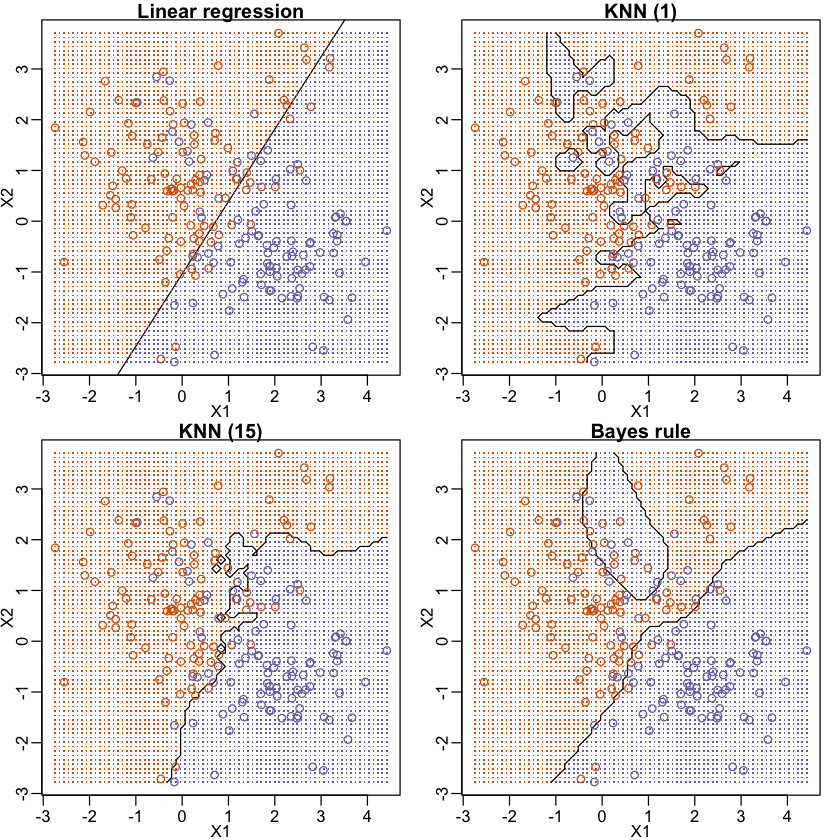

In [5]:
#### MAKE PNG HERE
#png("classification-plots-01.png", width=864, height=864, pointsize=12)
par(mfrow=c(2,2), mgp=c(1.25,.5,0), mar=c(2.25, 2.1, 1,1))

plot(x,col=cols,xlab="X1",ylab="X2",xlim=XLIM,ylim=YLIM,type="n")
abline(b,m)
points(newx,col=colshat,pch=".")
points(x,col=cols)
title("Linear regression")

# KNN (1)
yhat <- knn(x, newx, y, k=1)
colshat <- mycols[as.numeric(yhat)]

plot(x, xlab="X1", ylab="X2", xlim=XLIM, ylim=YLIM, type="n")
points(newx, col=colshat, pch=".")
contour(tmpx, tmpy, matrix(as.numeric(yhat),GS,GS), levels=c(1,2), add=TRUE, drawlabels=FALSE)
points(x, col=cols)
title("KNN (1)")

# KNN (15)
yhat <- knn(x, newx, y, k=15)
colshat <- mycols[as.numeric(yhat)]

plot(x, xlab="X1", ylab="X2", xlim=XLIM, ylim=YLIM, type="n")
points(newx, col=colshat, pch=".")
contour(tmpx, tmpy, matrix(as.numeric(yhat),GS,GS), levels=c(1,2), add=TRUE, drawlabels=FALSE)
points(x, col=cols)
title("KNN (15)")

# Bayes classifier
# probability of Y given X
p <- function(x) {
  p0 <- mean(dnorm(x[1], M0[,1], s) * dnorm(x[2], M0[,2], s))
  p1 <- mean(dnorm(x[1], M1[,1], s) * dnorm(x[2], M1[,2], s))
  p1/(p0+p1)
}

bayesrule <- apply(newx, 1, p)

colshat <- mycols[as.numeric(bayesrule>0.5)+1]

plot(x, xlab="X1", ylab="X2", xlim=XLIM, ylim=YLIM, type="n")
points(newx, col=colshat, pch=".")
contour(tmpx, tmpy, matrix(round(bayesrule),GS,GS), levels=c(1,2), add=TRUE, drawlabels=FALSE)
points(x, col=cols)
title("Bayes rule")


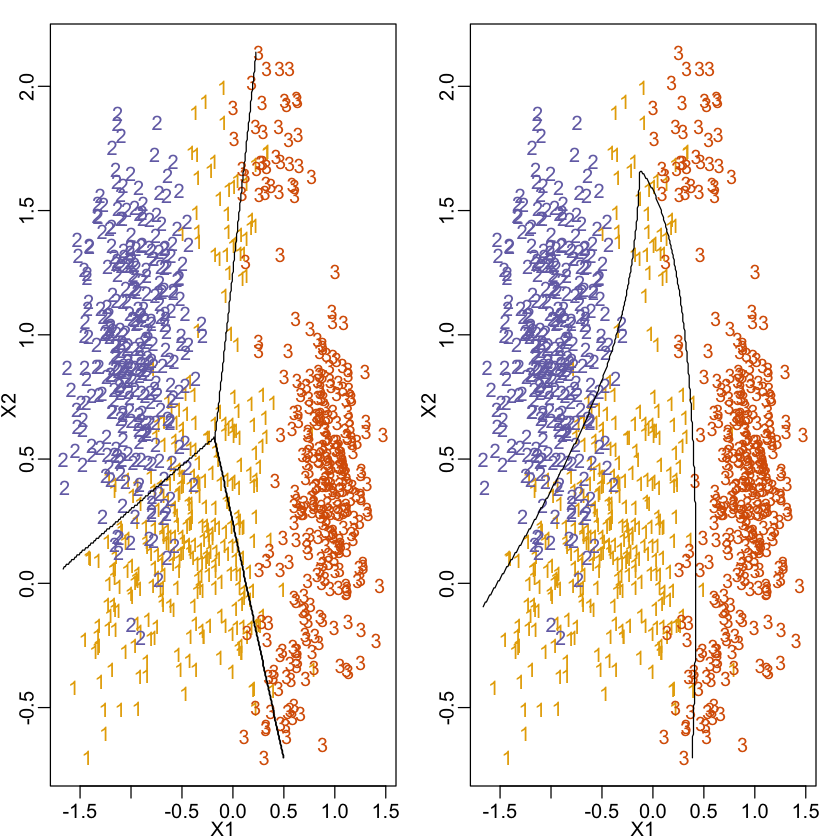

In [6]:
##################
# Plots showing linear regression boundaries
s <- sqrt(1/500)
s1 <- sqrt(1/350)
mycols <- brewer.pal(8, "Dark2")[c(6,3,2)]

set.seed(30)
GS <- 300
N <- 333

M1 <- mvrnorm(10, c(-1/2,0), matrix(c(3*s1,0,0,s1),2,2))
M1[1,] <- c(0,1.5)
M1[2,] <- c(0,.5)
M1[3,] <- c(-.5,.2)
x1 <- makeX(M1, n=N, sigma=diag(2)*s)

M2 <- mvrnorm(10, c(-1,1), diag(2)*s1)
x2 <- makeX(M2, n=N, sigma=diag(2)*s)

M3 <- mvrnorm(10, c(1,.5), matrix(c(s1/10, 0,0, s1*4),2,2))
M3[1,] <- c(0.5,-0.25)
M3[2,] <- c(0.4,1.75)
x3 <- makeX(M3, n=N, sigma=diag(2)*s)

X <- rbind(x1,x2,x3)
Index <- rep(1:3, c(N,N,N))
X1 <- X[,1]
X2 <- X[,2]

XLIM <- range(X1)
tmpx <- seq(XLIM[1], XLIM[2], len=GS)
YLIM <- range(X2)
tmpy <- seq(YLIM[1], YLIM[2], len=GS)
newx <- as.matrix(expand.grid(tmpx,tmpy))

Y <- t(sapply(Index, function(x) as.numeric((1:3)%in% x)))

# linear regression on indicator matrix
B <- apply(Y, 2, function(y) lm(y~X1+X2)$coef)
GridY <- cbind(1,newx) %*% B
GridG <- apply(GridY, 1, which.max)

#png("Plots/classification-plots-02.png", width=864, height=432, pointsize=12)
par(mfrow=c(1,2), mgp=c(1.25,.5,0), mar=c(2.25, 2.1, 1,1))
plot(X1, X2, col=mycols[Index], pch=as.character(Index))
contour(tmpx, tmpy, matrix(GridG, GS, GS), levels=c(1,2,3), add=TRUE, drawlabels=FALSE)

# linear regression with quadratic terms
X3 <- X1^2
X4 <- X2^2
X5 <- X1*X2

B <- apply(Y, 2, function(y) lm(y~X1+X2+X3+X4+X5)$coef)
GridY <- cbind(1,newx,newx^2,newx[,1]*newx[,2]) %*% B
GridG <- apply(GridY, 1, which.max)

plot(X1, X2, col=mycols[Index], pch=as.character(Index))
contour(tmpx, tmpy, matrix(GridG,GS,GS), levels=c(1,2), add=TRUE, drawlabels=FALSE)
#dev.off()


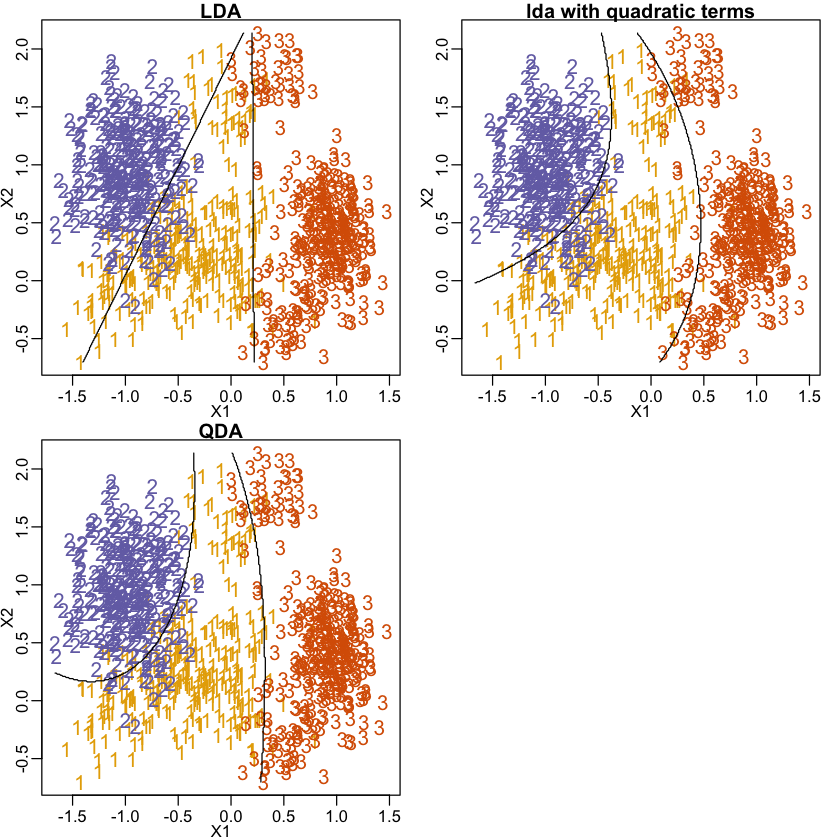

In [7]:
###
# plots showing lda and qda decision boundaries
Y <- as.factor(Index)

# lda
fit1 <- lda(Y~X1+X2)
Ghat <- as.numeric(predict(fit1, newdata=data.frame(X1=newx[,1], X2=newx[,2]))$class)

#png("Plots/classification-plots-07.png", width=864, height=864, pointsize=12)
par(mfrow=c(2,2), mgp=c(1.25,.5,0), mar=c(2.25, 2.1, 1,1))

plot(X1,X2, col=mycols[Index], pch=as.character(Index),cex=1.25)
contour(tmpx, tmpy, matrix(Ghat,GS,GS), levels=c(1,2), add=TRUE, drawlabels=FALSE)
title("LDA")

# lda with quadratic terms
fit2 <- lda(Y~X1+X2+X3+X4+X5)
Ghat <- as.numeric(predict(fit2, newdata=data.frame(X1=newx[,1],X2=newx[,2],X3=newx[,1]^2,X4=newx[,2]^2,X5=newx[,1]*newx[,2]))$class)

plot(X1,X2, col=mycols[Index], pch=as.character(Index), cex=1.25)
contour(tmpx, tmpy, matrix(Ghat,GS,GS), levels=c(1,2), add=TRUE, drawlabels=FALSE)
title("lda with quadratic terms")

# qda
fit3 <- qda(Y~X1+X2)
Ghat <- as.numeric(predict(fit3, newdata=data.frame(X1=newx[,1],X2=newx[,2]))$class)

plot(X1, X2, col=mycols[Index], pch=as.character(Index), cex=1.25)
contour(tmpx, tmpy, matrix(Ghat, GS, GS), levels=c(1,2), add=TRUE, drawlabels=FALSE)
title("QDA")

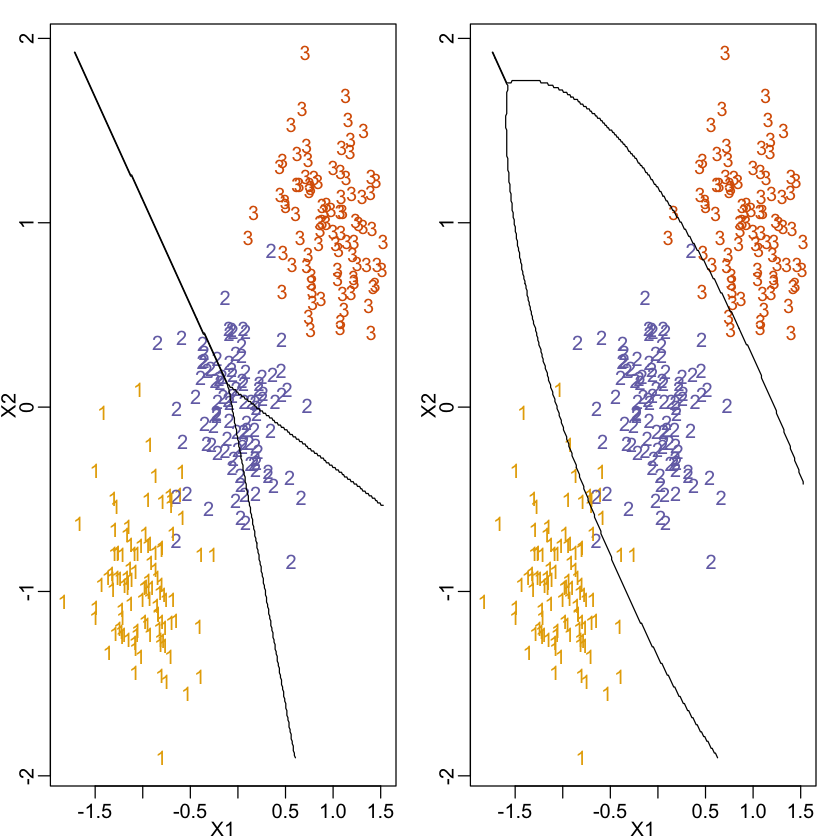

In [8]:
######
# Figure showing problem with indicator matrix regression
N <- 300
Gs <- 300

set.seed(3)
sigma <- 0.10
rho <- -0.15
Index <- sample(1:3, N, replace=TRUE)
mx <- c(-1,0,1)[Index]
X <- t(sapply(mx, function(mu)
  mvrnorm(1, c(mu,mu), Sigma=sigma*matrix(c(1,rho,rho,1),2,2))))

X1 <- X[,1]
X2 <- X[,2]
Y <- t(sapply(Index, function(x) as.numeric(1:3 %in% x)))

XLIM <- range(X1)
tmpx <- seq(XLIM[1], XLIM[2], len=GS)

YLIM <- range(X2)
tmpy <- seq(YLIM[1], YLIM[2], len=GS)

newx <- as.matrix(expand.grid(tmpx, tmpy))

B <- apply(Y, 2, function(y) lm(y~X1+X2)$coef)
Yhat1 <- cbind(1,X) %*% B

GridY <- cbind(1,newx) %*% B
GridG <- apply(GridY, 1, which.max)

#png("Plots/classification-plots-03.png", width=864, height=432, pointsize=12)
par(mfrow=c(1,2), mgp=c(1.25,.5,0), mar=c(2.25, 2.1, 1,1))

plot(X1, X2, col=mycols[Index], pch=as.character(Index))
contour(tmpx, tmpy, matrix(GridG, GS, GS), levels=c(1,2,3), add=TRUE, drawlabels=FALSE)

X3 <- X[,1]^2
X4 <- X[,2]^2
X5 <- X[,1] * X[,2]

B <- apply(Y, 2, function(y) lm(y~X1+X2+X3+X4+X5)$coef)
Yhat2 <- cbind(1,X,X^2,X[,1]*X[,2]) %*% B

GridY <- cbind(1,newx,newx^2,newx[,1]*newx[,2]) %*% B
GridG <- apply(GridY, 1, which.max)

plot(X1, X2, col=mycols[Index], pch=as.character(Index))
contour(tmpx, tmpy, matrix(GridG, GS, GS), levels=c(1,2,3), add=TRUE, drawlabels=FALSE)
# dev.off()